# Allsky CRE vs. cloud type as vertically stacked plots

We plot the overcast CRE vs. cloud type. 

## Load Standard and User Libraries

In [1]:
%matplotlib inline

import os, sys, copy, glob
import numpy as np
import datetime
import seaborn as sns
import pylab as pl

In [2]:
pl.rcParams['figure.figsize'] = (16.0, 8.0)
pl.rcParams['font.size'] = 24.0
pl.rcParams['lines.linewidth'] = 3
import xarray as xr

In [3]:
import nawdex_analysis.analysis.ave_cre
import nawdex_analysis.io.collector

import nawdex_analysis.plot.stacked_analysis_plots
reload( nawdex_analysis.plot.stacked_analysis_plots)

from nawdex_analysis.plot.stacked_analysis_plots import vert_stacked_exp_plot, get_exp_kws, get_plotting_order

## Read Radiation Fluxes

This is a slight jump forward in time. Now, average radiation fluxes are available for different CT categories.

In [4]:
rset= nawdex_analysis.io.collector.get_radflux4set( 'all', method = 'strict' )
#rset= nawdex_analysis.io.collector.get_radflux4set( 'all', method = 'all' )
#rset = nawdex_analysis.io.collector.get_radflux4set( 2 )


## Convert Flux to CRE (Scaling !!!!)

In [5]:
nawdex_analysis.analysis.ave_cre.radflux2cre( rset, scaling = True, new_factor = 0.88, old_factor = 0.9 )

In [6]:
rset

<xarray.Dataset>
Dimensions:          (ct: 11, idname: 16, time: 264)
Coordinates:
  * idname           (idname) object '10km_oneMom_Conv' ... 'msevi-scaled'
  * ct               (ct) |S18 'clear_ocean' 'very low' ... 'fractional'
  * time             (time) datetime64[ns] 2016-09-21 ... 2016-10-05T23:00:00
Data variables:
    afrac            (time, ct, idname) float64 22.11 21.22 ... 8.958 8.958
    swf_up_clear     (idname, time, ct) float64 0.0 0.0 0.0 0.0 ... 0.0 nan 0.0
    swf_net_clear    (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    swf_down         (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lwf_clear        (time, ct, idname) float64 276.2 276.4 ... 272.9 270.9
    swf_up           (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    swf_net          (time, ct, idname) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lwf              (time, ct, idname) float64 274.5 274.3 ... 255.8 255.8
    expname          (time, idname) object 'naw

## Adding fractional and vary low clouds

In [7]:
cset = rset.sel(ct = 'very low') + rset.sel(ct = 'fractional')
cset = cset.expand_dims('ct')
cset['ct'] = ['very low / fractional']

In [8]:
cset = xr.concat( [cset, rset], dim = 'ct' )

## Rename CT labels

In [9]:
ctnames = cset.ct.data
ctnames[8] = 'semi. moderately thick'
ctnames[4] = 'mid-level'

## all NaNs should be zero of the fraction-weighted radflux contribution

The problems with the NaNs is that the average values and std of shortwave fluxes change strongly if some NaNs mask out a certain time at the day.

In [10]:
mask = cset.notnull()
cset = cset.where( mask, 0)

## Calculate Mean and STD

In [11]:
catlist = list( cset.ct.data )

remove_list = ['clear_ocean', 'semi. above', 'very low', 'fractional']

for rm_cat in remove_list:
    catlist.remove(rm_cat)


idlist = list( cset.idname.data )
idlist.remove( 'msevi-not_scaled' )

dset = cset.sel(ct = catlist, idname = idlist)
daily_mean = dset.groupby('time.day').mean('time')
# dvar = daily_mean.quantile([0.25, 0.5, 0.75], dim = 'day').diff('quantile')
dvar = daily_mean.std('day')
mvar = dset.mean('time')

In [12]:
dvar_q = ( daily_mean.quantile(0.84, 'day') - daily_mean.quantile(0.16, 'day')  ) /2.

## Plotting

In [13]:
from nawdex_analysis.plot.legend import plegend

In [16]:
mvar.ct.data = ['very low /\nfractional', 'low', 'mid-level', 'high opaque',
       'very high\nopaque', 'semi. thin', 'semi.\nmoderately thick',
       'semi. thick']
dvar.ct.data = mvar.ct.data
dvar_q.ct.data = mvar.ct.data


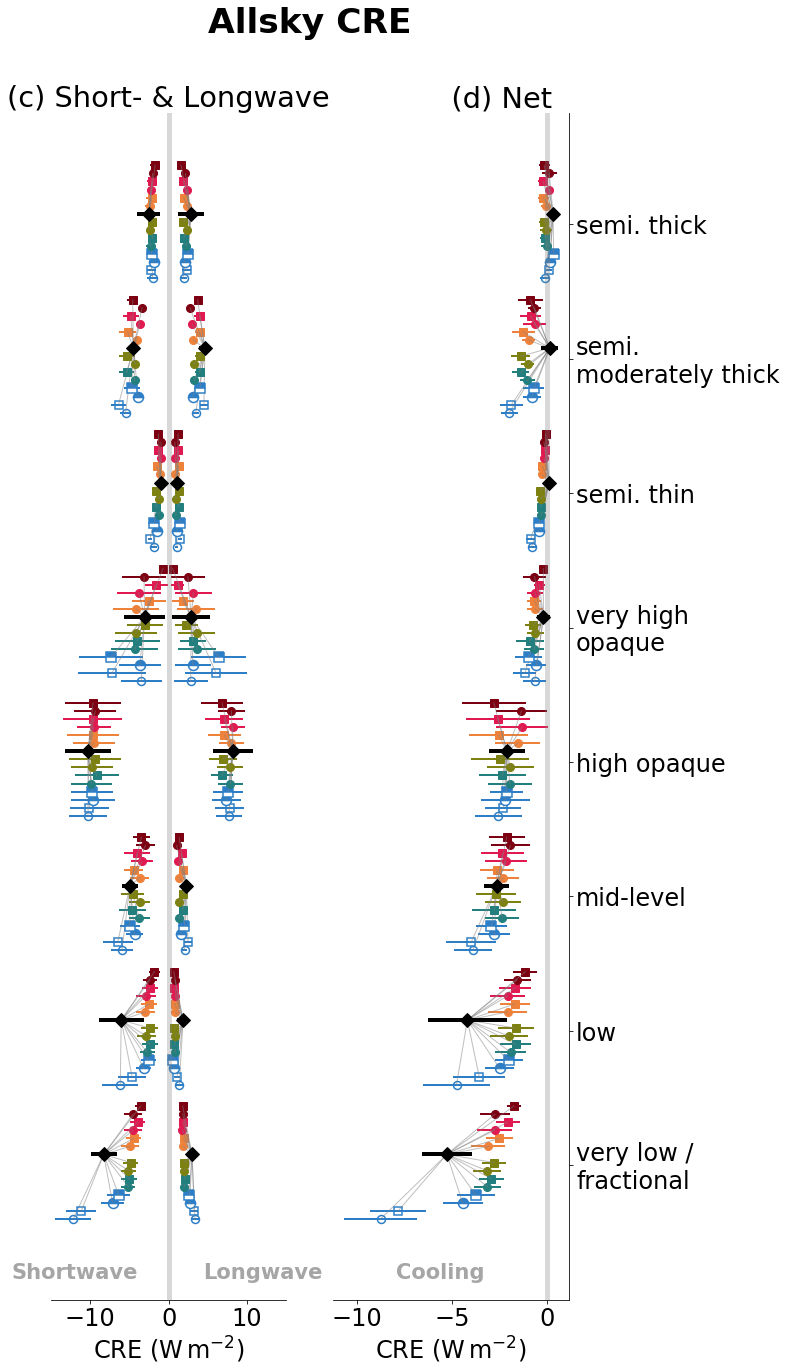

In [19]:
grey_fontsize = 21
fac = 0.6


fig, ax = pl.subplots( ncols = 2, figsize = (30*fac, 35*fac), )

pl.sca(ax[0])
vert_stacked_exp_plot( mvar, 'scre_contrib' , var_err = dvar_q, doffset =0.06)
vert_stacked_exp_plot( mvar, 'lcre_contrib' , var_err = dvar_q, doffset =0.06)

xlim = pl.xlim(-15, 15)

pl.title('(c) Short- & Longwave')


pl.sca(ax[1])
vert_stacked_exp_plot( mvar, 'net_cre_contrib' , var_err = dvar_q, doffset =0.06)
pl.title('           (d) Net')
xlim = pl.xlim()

#sns.despine(ax = ax[0])
#sns.despine(left = True, ax = ax[1])
#ax[1].set_yticks([])
sns.despine(left = True, right = True, ax = ax[0])
sns.despine(left = True, right = False, ax = ax[1])
ax[0].set_yticks([])


### Extra Text Labels
### ==================
pl.sca( ax[0] )
pl.text( -12, -0.8, 'Shortwave', 
            color = 'gray', ha = 'center', va = 'center', alpha = 0.7, 
            fontweight = 'bold', fontsize = grey_fontsize)

pl.text( 12, -0.8, 'Longwave', 
            color = 'gray', ha = 'center', va = 'center', alpha = 0.7, 
            fontweight = 'bold', fontsize = grey_fontsize)


pl.sca( ax[1] )
pl.text( xlim[0] / 2, -0.8, 'Cooling', 
            color = 'gray', ha = 'center', va = 'center', alpha = 0.7, 
            fontweight = 'bold', fontsize = grey_fontsize)

#pl.text( xlim[1] * 0.8, -0.8, 'Warming', 
#            color = 'gray', ha = 'center', va = 'center', alpha = 0.7, 
#            fontweight = 'bold', fontsize = 'large')

#plegend()

for a in ax:
    a.axvline(0, color = 'gray', lw = 5, alpha = 0.3)
    a.set_xlabel('CRE ($\mathrm{W\, m^{-2}}$)')
    a.set_ylim(-1,None)

pl.suptitle('Allsky CRE', fontsize = 'x-large', fontweight = 'bold')

pl.subplots_adjust( left = 0.3, right = 0.7, top = 0.91 )
pl.savefig( '../pics/cre_allsky-vs-ct.png', dpi = 300,)


## Plot Biases

In [ ]:
daily_bias = daily_mean - daily_mean.sel(idname = 'msevi-scaled')


idlist = list( daily_bias.idname.data )
idlist.remove('msevi-scaled')

daily_bias = daily_bias.sel(idname = idlist)

mbias = daily_bias.mean('day')
dbias = daily_bias.std('day')



In [ ]:
fig, ax = pl.subplots( ncols = 3,  figsize = (28, 13), )

pl.sca(ax[0])
vert_stacked_exp_plot( mbias, 'scre_contrib' , 
                       var_err = dbias, doffset = 0.06, 
                       connect2obs = False, obsref_name = '2km_oneMom_noConv')
sns.despine(ax = ax[0])
pl.title('(a) Shortwave', pad = 20)

pl.sca(ax[1])
vert_stacked_exp_plot( mbias, 'lcre_contrib' , 
                       var_err = dbias, doffset = 0.06, 
                       connect2obs = False, obsref_name = '2km_oneMom_noConv')
pl.yticks([])
pl.title('(b) Longwave', pad = 20)

pl.sca(ax[2])
vert_stacked_exp_plot( mbias, 'net_cre_contrib' , 
                       var_err = dbias, doffset = 0.06, 
                       connect2obs = False, obsref_name = '2km_oneMom_noConv')
pl.yticks([])
pl.title('(c) Net', pad = 20)

pl.suptitle('Allsky CRE Biases', fontsize = 'x-large', fontweight = 'bold')
for a in ax:
    a.set_xlim(-7,7)
    a.axvline(0, color = 'gray', lw = 5, alpha = 0.3)
    a.set_xlabel('CRE bias ($\mathrm{W\, m^{-2}}$)')
    
for a in ax[1:]:
    sns.despine(left = True, ax = a)
    
pl.axvline(0, color = 'gray', lw = 5, alpha = 0.3)
pl.subplots_adjust( left = 0.3, right = 0.7 )
pl.savefig( '../pics/cre-allsky_bias-vs-ct.png', dpi = 300,)


## Old CRE biases Plot with wrong error bars

```python
mbias =  mvar - mvar.sel(idname = 'msevi-scaled') 

idlist = list( mbias.idname.data )
idlist.remove('msevi-scaled')

mbias = mbias.sel(idname = idlist)


dbias = np.sqrt( dvar**2  + dvar.sel(idname = 'msevi-scaled')**2 )

fig, ax = pl.subplots( ncols = 3,  figsize = (28, 13), )

pl.sca(ax[0])
vert_stacked_exp_plot( mbias, 'scre_contrib' , 
                       var_err = dbias, doffset = 0.06, 
                       connect2obs = False, obsref_name = '2km_oneMom_noConv')
sns.despine(ax = ax[0])
pl.title('(a) Shortwave', pad = 20)

pl.sca(ax[1])
vert_stacked_exp_plot( mbias, 'lcre_contrib' , 
                       var_err = dbias, doffset = 0.06, 
                       connect2obs = False, obsref_name = '2km_oneMom_noConv')
pl.yticks([])
pl.title('(b) Longwave', pad = 20)

pl.sca(ax[2])
vert_stacked_exp_plot( mbias, 'net_cre_contrib' , 
                       var_err = dbias, doffset = 0.06, 
                       connect2obs = False, obsref_name = '2km_oneMom_noConv')
pl.yticks([])
pl.title('(c) Net', pad = 20)

pl.suptitle('Allsky CRE Biases', fontsize = 'x-large', fontweight = 'bold')
for a in ax:
    a.set_xlim(-7,7)
    a.axvline(0, color = 'gray', lw = 5, alpha = 0.3)
    a.set_xlabel('CRE bias ($\mathrm{W\, m^{-2}}$)')
    
for a in ax[1:]:
    sns.despine(left = True, ax = a)
    
pl.axvline(0, color = 'gray', lw = 5, alpha = 0.3)
pl.subplots_adjust( left = 0.3, right = 0.7 )
# pl.savefig( '../pics/cre-allsky_bias-vs-ct.png', dpi = 300,)

``` 